<a href="https://colab.research.google.com/github/devansurf/Ocean-MultiClass/blob/main/Ocean_Multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ocean Animals Multi-classification model!


In [ ]:
#Fetch dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

In [ ]:
#Libaries
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import optuna #tuner
import re
import random
import seaborn as sns
from collections import Counter
from itertools import chain

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torch.nn import Module, Conv2d, ConvTranspose2d, Dropout, BatchNorm2d
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, GaussianBlur
from torch.utils.data import random_split


from PIL import Image

from collections import Counter
from tqdm import tqdm
from IPython.display import display, Math, Latex
from sklearn.utils import resample
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split

In [ ]:
#directory
root_dir = '/content/drive/MyDrive/MachineLearning/ocean-dataset'

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [ ]:
#Configuration
class Config:
    #CNN settings
    learning_rate = 2.715011573252679e-05
    num_epochs = 50
    batch_size = 32
    dropout = 0.5
    img_dimensions = (152, 152)

    #dataset settings
    num_classifications = 23 #max 23
    target_count = 600

    training_proportion = 0.7
    validation_proportion = 0.2

    #misc
    display_plots = False
    allow_tuner = False

# Helper Functions


In [ ]:
def to_numpy(x):
    return x.detach().cpu().numpy()

In [ ]:
#Calculate mean std helper:
def calculate_mean_std(dataset):
    dataset_dataloader = DataLoader(
        dataset, batch_size=len(dataset), num_workers=2
    ) # this will allow us to iterate through images in batches
    data = next(iter(dataset_dataloader))
    return data[0].mean(), data[0].std()

In [ ]:
#Function to balance a subset
def balance(image_paths, labels, target_count=600):
    balanced_image_paths = []
    balanced_labels = []

    label_counts = Counter(labels)
    for label in label_counts:
        label_indices = [i for i, lbl in enumerate(labels) if lbl == label]
        if label_counts[label] > target_count:
            # undersampling
            balanced_indices = random.sample(label_indices, k=target_count)
        else:
            # oversampling
            balanced_indices = random.choices(label_indices, k=target_count)

        balanced_image_paths.extend([image_paths[i] for i in balanced_indices])
        balanced_labels.extend([label] * len(balanced_indices))

    return balanced_image_paths, balanced_labels

In [ ]:
def show_random_images(subset, subset_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Randomly select an index
        idx = random.randint(0, len(subset) - 1)

        # Get the image and label
        image, label= subset[idx]
        # Convert the tensor image to a NumPy array for visualization
        image_np = image.permute(1, 2, 0).numpy()

        # Subplot for each image
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image_np)
        plt.title(f'{subset_name} - Label: {label}')
        plt.axis('off')
    plt.show()

In [ ]:
def show_distribution(subset, subset_name):
    counts = {}
    for _, label in subset:
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1

    counts_series = pd.Series(counts)

    # Plot the label counts
    plt.figure(figsize=(15, 5))
    # Plot original counts
    counts_series.plot(kind='bar', color='blue', label='Original')

    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title('Distribution of Labels in: ' + subset_name)
    plt.legend()
    plt.show()

# Custom Dataset Class


In [ ]:
class OceanDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):

        assert len(image_paths) == len(labels), "Length mismatch between images and labels"
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# CNN

In [ ]:
class OceanCNN(nn.Module):
    def __init__(self, dropout=0.5, img_dimensions=(128,128)):
        super(OceanCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        def conv_output_size(size, kernel_size=3, stride=1, padding=1):
            return (size - kernel_size + 2 * padding) // stride + 1

        size = conv_output_size(img_dimensions[0]) # After first conv layer
        size = size // 2 # After first pooling
        size = conv_output_size(size) # After second conv
        size = size // 2 # After second pooling
        size = conv_output_size(size) # After third conv
        size = size // 2 # After third pooling
        self.final_size = size * size * 128 # Adjusted for 128 filters in the last conv layer


        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(self.final_size, 512)
        self.fc2 = nn.Linear(512, Config.num_classifications)
        self.dropout = nn.Dropout(dropout)



    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, self.final_size)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Training Function


In [ ]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_model(learning_rate, epochs, dropout, img_dimensions, train_loader, valid_loader):
    torch.manual_seed(69)  # Set seed

    model = OceanCNN(dropout=dropout, img_dimensions=img_dimensions)
    print(model)  # Print model architecture

    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

    acc_hist_train = []
    acc_hist_val = []
    train_losses = []
    val_losses = []

    # Early stopping logic here
    early_stopper = EarlyStopper(patience=10, min_delta=0.1)

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        acc_hist_train.append(train_accuracy)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()


        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_accuracy = correct_val / total_val

        if early_stopper.early_stop(valid_loss):
            print(f'Early Stop -> Epoch = {epoch}')
            break

        if (epoch > 1 and valid_loss < np.min(val_losses)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint_loss.pt')
            print("Validation loss checkpoint saved!")

        if (epoch > 1 and valid_accuracy > np.max(acc_hist_val)) or epoch == 1:
            torch.save(model.state_dict(), 'checkpoint_acc.pt')
            print("Validation acc checkpoint saved!")


        acc_hist_val.append(valid_accuracy)
        val_losses.append(valid_loss)

        print("valid loss is: ", valid_loss)
        print("minimum of the losses is: ", np.min(val_losses))

        print(f"Epoch: {epoch}")
        print(f"Train Acc: {train_accuracy:.3f}")
        print(f"Val Acc: {valid_accuracy:.3f}")
        print(f"Train Loss: {train_loss:.3f}")
        print(f"Val Loss: {valid_loss:.3f}")
        print("---------------------------------------------")

    model.eval()
    return model, acc_hist_train, acc_hist_val, train_losses, val_losses

# Format Dataset


In [ ]:
#Loop through species folders, up to num_classifications
def getData(num_classifications):
    all_image_paths = []
    all_labels = []
    species_folders = sorted(os.listdir(root_dir))[:num_classifications]

    for label, species in enumerate(species_folders):
        species_dir = os.path.join(root_dir, species)
        if os.path.isdir(species_dir):
            for image_name in os.listdir(species_dir):
                image_path = os.path.join(species_dir, image_name)
                if os.path.isfile(image_path):
                    all_image_paths.append(image_path)
                    all_labels.append(label)  # Using index as label

    return all_image_paths, all_labels

#TODO, make sure to split subsets by each classification category, so that training is non-biased (for every species split evenly)
all_image_paths, all_labels = getData(Config.num_classifications)

dataset = OceanDataset(all_image_paths, all_labels, transforms.Compose([ transforms.Resize(Config.img_dimensions), transforms.ToTensor(),]))
mean, std = 0.3758, 0.2585
print('mean: ', mean)
print('std: ', std)
# mean:  tensor(0.3758)
# std:  tensor(0.2585)
#Define transforms (augmentations)
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(Config.img_dimensions[0], scale=(0.9, 1.0)),  # Random zoom,
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

validation_transform = transforms.Compose([
    transforms.Resize(Config.img_dimensions),
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])


def split_dataset(num_classifications, all_image_paths, all_labels):

    # Create empty lists to store split data
    train_paths, validation_paths, test_paths = [], [], []
    train_labels, validation_labels, test_labels = [], [], []

    #This ensures equal representation for each class

    for label in range(num_classifications):

        # Filter paths and labels for the current label
        label_paths = [path for path, l in zip(all_image_paths, all_labels) if l == label]
        label_labels = [l for l in all_labels if l == label]


        #calculate lengths
        total_size = len(label_labels)
        train_size = int(total_size * Config.training_proportion)
        valid_size = int(total_size * Config.validation_proportion)
        test_size = total_size - train_size - valid_size

        # Split into training and temporary set (validation + test)
        paths_train, paths_temp, labels_train, labels_temp = train_test_split(
            label_paths, label_labels, train_size=train_size, random_state=42)

        # Split the temporary set into validation and test sets
        validation_size_adjusted = valid_size / (valid_size + test_size)
        paths_valid, paths_test, labels_valid, labels_test = train_test_split(
            paths_temp, labels_temp, train_size=validation_size_adjusted, random_state=42)

        # Append to main lists
        train_paths.extend(paths_train)
        validation_paths.extend(paths_valid)
        test_paths.extend(paths_test)
        train_labels.extend(labels_train)
        validation_labels.extend(labels_valid)
        test_labels.extend(labels_test)

    return train_paths, train_labels, validation_paths, validation_labels, test_paths, test_labels

#balance dataset first
all_image_paths, all_labels = balance(all_image_paths, all_labels, Config.target_count)
#call the split dataset function
train_image_paths, train_labels, valid_image_paths, valid_labels, test_image_paths, test_labels = split_dataset(Config.num_classifications, all_image_paths, all_labels)

#Oversample the training subset
#balanced_train_image_paths, balanced_train_labels = balance(train_image_paths, train_labels, Config.target_count)

#data was split this way in order to apply different transforms across subsets
train_dataset = OceanDataset(train_image_paths, train_labels, transform=train_transform)
valid_dataset = OceanDataset(valid_image_paths, valid_labels, transform=validation_transform)
test_dataset =  OceanDataset(test_image_paths, test_labels, transform=validation_transform)

#creating data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False)


mean:  0.3758
std:  0.2585


# Visualize formatted dataset

In [ ]:
if Config.display_plots:
    show_random_images(train_dataset, "Train Dataset")
    show_random_images(valid_dataset, "Valid Dataset")
    show_random_images(test_dataset, "Test Dataset")

    #show_distribution(dataset, "Raw_Dataset")
    show_distribution(train_dataset, "Train_Dataset")
    show_distribution(valid_dataset, "Valid_Dataset")
    show_distribution(test_dataset, "Test_Dataset")

# Training Tuner

In [ ]:
#tuner function
def tuner(trial):
    # Define the hyperparameters to be tuned
    learning_rate = trial.suggest_float('learning_rate', 0.00001, 0.0001)
    dropout = Config.dropout#trial.suggest_float('dropout', 0, 0.6)
    img_dimension = Config.img_dimensions[0] #trial.suggest_int('img_dimension', 128, 256, step= 8) #128 to 256 with steps of 8
    batch_size = Config.batch_size#trial.suggest_int('batch_size', 8, 64, step = 8)
    epochs = 5
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(img_dimension, scale=(0.9, 1.0)),  # Random zoom,
        transforms.ToTensor(),

    ])

    validation_transform = transforms.Compose([
        transforms.Resize((img_dimension, img_dimension)),
        transforms.ToTensor(),
    ])

    #Custom dataset for tuner
    train_dataset = OceanDataset(train_image_paths, train_labels, transform=train_transform)
    valid_dataset = OceanDataset(valid_image_paths, valid_labels, transform=validation_transform)
    test_dataset =  OceanDataset(test_image_paths, test_labels, transform=validation_transform)

    #creating data loaders for each set
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(learning_rate, epochs, dropout, (img_dimension,img_dimension), train_loader, valid_loader)
    return max(acc_hist_val)

if Config.allow_tuner:
    study = optuna.create_study(direction='maximize')
    study.optimize(tuner, n_trials=30)

    best_params = study.best_params
    print("Best hyperparameters: ", best_params)

# Train the Model


In [ ]:
model, acc_hist_train, acc_hist_val, train_losses, val_losses = train_model(Config.learning_rate, Config.num_epochs, Config.dropout, Config.img_dimensions, train_loader, valid_loader)

OceanCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46208, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=23, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


100%|██████████| 302/302 [01:01<00:00,  4.93it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  2.3760413283887116
minimum of the losses is:  2.3760413283887116
Epoch: 1
Train Acc: 0.191
Val Acc: 0.303
Train Loss: 2.696
Val Loss: 2.376
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.25it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  2.1982410766076352
minimum of the losses is:  2.1982410766076352
Epoch: 2
Train Acc: 0.267
Val Acc: 0.344
Train Loss: 2.421
Val Loss: 2.198
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.24it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  2.093892694901729
minimum of the losses is:  2.093892694901729
Epoch: 3
Train Acc: 0.312
Val Acc: 0.371
Train Loss: 2.271
Val Loss: 2.094
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.24it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.9866213663764622
minimum of the losses is:  1.9866213663764622
Epoch: 4
Train Acc: 0.345
Val Acc: 0.408
Train Loss: 2.158
Val Loss: 1.987
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.19it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.9372413047845813
minimum of the losses is:  1.9372413047845813
Epoch: 5
Train Acc: 0.379
Val Acc: 0.421
Train Loss: 2.045
Val Loss: 1.937
---------------------------------------------


100%|██████████| 302/302 [00:49<00:00,  6.14it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.8710275767506033
minimum of the losses is:  1.8710275767506033
Epoch: 6
Train Acc: 0.396
Val Acc: 0.447
Train Loss: 1.977
Val Loss: 1.871
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.23it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.8407988565555518
minimum of the losses is:  1.8407988565555518
Epoch: 7
Train Acc: 0.414
Val Acc: 0.449
Train Loss: 1.904
Val Loss: 1.841
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.20it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.7734684895778048
minimum of the losses is:  1.7734684895778048
Epoch: 8
Train Acc: 0.445
Val Acc: 0.476
Train Loss: 1.811
Val Loss: 1.773
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.19it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.724249816286391
minimum of the losses is:  1.724249816286391
Epoch: 9
Train Acc: 0.466
Val Acc: 0.494
Train Loss: 1.747
Val Loss: 1.724
---------------------------------------------


100%|██████████| 302/302 [00:49<00:00,  6.16it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.685602843243143
minimum of the losses is:  1.685602843243143
Epoch: 10
Train Acc: 0.485
Val Acc: 0.508
Train Loss: 1.677
Val Loss: 1.686
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.20it/s]


Validation loss checkpoint saved!
valid loss is:  1.6701599349146303
minimum of the losses is:  1.6701599349146303
Epoch: 11
Train Acc: 0.511
Val Acc: 0.506
Train Loss: 1.604
Val Loss: 1.670
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.20it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.6357109676236692
minimum of the losses is:  1.6357109676236692
Epoch: 12
Train Acc: 0.529
Val Acc: 0.513
Train Loss: 1.549
Val Loss: 1.636
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.26it/s]


Validation acc checkpoint saved!
valid loss is:  1.6415094949197078
minimum of the losses is:  1.6357109676236692
Epoch: 13
Train Acc: 0.556
Val Acc: 0.516
Train Loss: 1.475
Val Loss: 1.642
---------------------------------------------


100%|██████████| 302/302 [00:49<00:00,  6.16it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.5881195597026658
minimum of the losses is:  1.5881195597026658
Epoch: 14
Train Acc: 0.573
Val Acc: 0.536
Train Loss: 1.420
Val Loss: 1.588
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.39it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.5537827474483545
minimum of the losses is:  1.5537827474483545
Epoch: 15
Train Acc: 0.585
Val Acc: 0.536
Train Loss: 1.368
Val Loss: 1.554
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.33it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.5071710959724758
minimum of the losses is:  1.5071710959724758
Epoch: 16
Train Acc: 0.605
Val Acc: 0.555
Train Loss: 1.311
Val Loss: 1.507
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.42it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.4966971000035605
minimum of the losses is:  1.4966971000035605
Epoch: 17
Train Acc: 0.616
Val Acc: 0.561
Train Loss: 1.283
Val Loss: 1.497
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.46it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.4687555919522826
minimum of the losses is:  1.4687555919522826
Epoch: 18
Train Acc: 0.639
Val Acc: 0.568
Train Loss: 1.217
Val Loss: 1.469
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.34it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.437957963908928
minimum of the losses is:  1.437957963908928
Epoch: 19
Train Acc: 0.647
Val Acc: 0.578
Train Loss: 1.172
Val Loss: 1.438
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.33it/s]


Validation loss checkpoint saved!
valid loss is:  1.4241550236508467
minimum of the losses is:  1.4241550236508467
Epoch: 20
Train Acc: 0.666
Val Acc: 0.576
Train Loss: 1.124
Val Loss: 1.424
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.30it/s]


valid loss is:  1.4467812802480615
minimum of the losses is:  1.4241550236508467
Epoch: 21
Train Acc: 0.686
Val Acc: 0.574
Train Loss: 1.074
Val Loss: 1.447
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.42it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.4094644591428231
minimum of the losses is:  1.4094644591428231
Epoch: 22
Train Acc: 0.686
Val Acc: 0.589
Train Loss: 1.052
Val Loss: 1.409
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.25it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.3558157691057178
minimum of the losses is:  1.3558157691057178
Epoch: 23
Train Acc: 0.704
Val Acc: 0.603
Train Loss: 1.009
Val Loss: 1.356
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.32it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.3426183548526487
minimum of the losses is:  1.3426183548526487
Epoch: 24
Train Acc: 0.721
Val Acc: 0.614
Train Loss: 0.964
Val Loss: 1.343
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.34it/s]


Validation loss checkpoint saved!
valid loss is:  1.3392508615618166
minimum of the losses is:  1.3392508615618166
Epoch: 25
Train Acc: 0.728
Val Acc: 0.610
Train Loss: 0.932
Val Loss: 1.339
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.27it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.3164976859438247
minimum of the losses is:  1.3164976859438247
Epoch: 26
Train Acc: 0.735
Val Acc: 0.617
Train Loss: 0.914
Val Loss: 1.316
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.44it/s]


Validation loss checkpoint saved!
valid loss is:  1.3126405627831168
minimum of the losses is:  1.3126405627831168
Epoch: 27
Train Acc: 0.742
Val Acc: 0.613
Train Loss: 0.878
Val Loss: 1.313
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.45it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.3097219861072043
minimum of the losses is:  1.3097219861072043
Epoch: 28
Train Acc: 0.758
Val Acc: 0.621
Train Loss: 0.833
Val Loss: 1.310
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.38it/s]


valid loss is:  1.324524351047433
minimum of the losses is:  1.3097219861072043
Epoch: 29
Train Acc: 0.772
Val Acc: 0.620
Train Loss: 0.803
Val Loss: 1.325
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.31it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.2878446877866552
minimum of the losses is:  1.2878446877866552
Epoch: 30
Train Acc: 0.776
Val Acc: 0.621
Train Loss: 0.773
Val Loss: 1.288
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.38it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.2746478334717128
minimum of the losses is:  1.2746478334717128
Epoch: 31
Train Acc: 0.783
Val Acc: 0.634
Train Loss: 0.747
Val Loss: 1.275
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.26it/s]


Validation loss checkpoint saved!
valid loss is:  1.2723960852277452
minimum of the losses is:  1.2723960852277452
Epoch: 32
Train Acc: 0.797
Val Acc: 0.631
Train Loss: 0.724
Val Loss: 1.272
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.45it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.2466508691725524
minimum of the losses is:  1.2466508691725524
Epoch: 33
Train Acc: 0.800
Val Acc: 0.644
Train Loss: 0.699
Val Loss: 1.247
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.32it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.2326566703077675
minimum of the losses is:  1.2326566703077675
Epoch: 34
Train Acc: 0.803
Val Acc: 0.647
Train Loss: 0.682
Val Loss: 1.233
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.29it/s]


valid loss is:  1.2341342991676882
minimum of the losses is:  1.2326566703077675
Epoch: 35
Train Acc: 0.814
Val Acc: 0.638
Train Loss: 0.653
Val Loss: 1.234
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.36it/s]


valid loss is:  1.2444157552891884
minimum of the losses is:  1.2326566703077675
Epoch: 36
Train Acc: 0.825
Val Acc: 0.647
Train Loss: 0.620
Val Loss: 1.244
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.38it/s]


valid loss is:  1.2356333297231923
minimum of the losses is:  1.2326566703077675
Epoch: 37
Train Acc: 0.832
Val Acc: 0.646
Train Loss: 0.602
Val Loss: 1.236
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.43it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.2061765611171722
minimum of the losses is:  1.2061765611171722
Epoch: 38
Train Acc: 0.836
Val Acc: 0.660
Train Loss: 0.579
Val Loss: 1.206
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.38it/s]


valid loss is:  1.2300512813139652
minimum of the losses is:  1.2061765611171722
Epoch: 39
Train Acc: 0.848
Val Acc: 0.646
Train Loss: 0.557
Val Loss: 1.230
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.38it/s]


Validation acc checkpoint saved!
valid loss is:  1.2118331414201986
minimum of the losses is:  1.2061765611171722
Epoch: 40
Train Acc: 0.845
Val Acc: 0.662
Train Loss: 0.549
Val Loss: 1.212
---------------------------------------------


100%|██████████| 302/302 [00:48<00:00,  6.20it/s]


valid loss is:  1.2142837637576505
minimum of the losses is:  1.2061765611171722
Epoch: 41
Train Acc: 0.855
Val Acc: 0.660
Train Loss: 0.518
Val Loss: 1.214
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.38it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.1926979573740475
minimum of the losses is:  1.1926979573740475
Epoch: 42
Train Acc: 0.863
Val Acc: 0.662
Train Loss: 0.501
Val Loss: 1.193
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.41it/s]


Validation acc checkpoint saved!
valid loss is:  1.2128884069297625
minimum of the losses is:  1.1926979573740475
Epoch: 43
Train Acc: 0.859
Val Acc: 0.664
Train Loss: 0.497
Val Loss: 1.213
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.43it/s]


Validation loss checkpoint saved!
valid loss is:  1.1856920364974202
minimum of the losses is:  1.1856920364974202
Epoch: 44
Train Acc: 0.864
Val Acc: 0.663
Train Loss: 0.494
Val Loss: 1.186
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.39it/s]


Validation acc checkpoint saved!
valid loss is:  1.1870694712452265
minimum of the losses is:  1.1856920364974202
Epoch: 45
Train Acc: 0.872
Val Acc: 0.666
Train Loss: 0.461
Val Loss: 1.187
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.31it/s]


Validation acc checkpoint saved!
valid loss is:  1.1867017288138901
minimum of the losses is:  1.1856920364974202
Epoch: 46
Train Acc: 0.875
Val Acc: 0.674
Train Loss: 0.446
Val Loss: 1.187
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.37it/s]


valid loss is:  1.2154318716215051
minimum of the losses is:  1.1856920364974202
Epoch: 47
Train Acc: 0.882
Val Acc: 0.670
Train Loss: 0.437
Val Loss: 1.215
---------------------------------------------


100%|██████████| 302/302 [00:47<00:00,  6.36it/s]


valid loss is:  1.190188637073489
minimum of the losses is:  1.1856920364974202
Epoch: 48
Train Acc: 0.886
Val Acc: 0.672
Train Loss: 0.416
Val Loss: 1.190
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.46it/s]


Validation loss checkpoint saved!
Validation acc checkpoint saved!
valid loss is:  1.1774748033371525
minimum of the losses is:  1.1774748033371525
Epoch: 49
Train Acc: 0.889
Val Acc: 0.678
Train Loss: 0.402
Val Loss: 1.177
---------------------------------------------


100%|██████████| 302/302 [00:46<00:00,  6.44it/s]


Validation acc checkpoint saved!
valid loss is:  1.203828966099283
minimum of the losses is:  1.1774748033371525
Epoch: 50
Train Acc: 0.890
Val Acc: 0.679
Train Loss: 0.392
Val Loss: 1.204
---------------------------------------------


# Evaluation


In [ ]:
load_acc_checkpoint = True
if load_acc_checkpoint:
    model = OceanCNN(dropout=Config.dropout, img_dimensions=Config.img_dimensions)
    model.load_state_dict(torch.load('checkpoint_acc.pt'))
    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU


In [ ]:
#Load loss checkpoint if requested
load_loss_checkpoint = True
if load_loss_checkpoint:
    model = OceanCNN(dropout=Config.dropout, img_dimensions=Config.img_dimensions)
    model.load_state_dict(torch.load('checkpoint_loss.pt'))
    if torch.cuda.is_available():
        model = model.to('cuda')  # Move your model to GPU

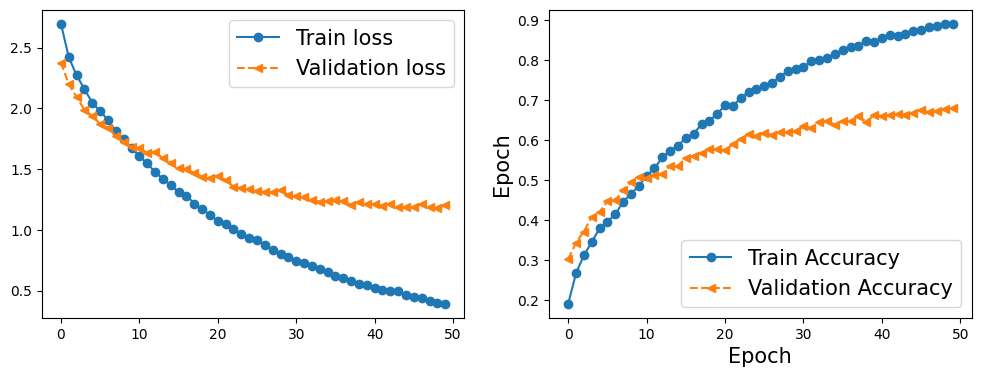

In [ ]:
#Plot graphs

loss_axis = list(range(len(train_losses)))
val_axis = list(range(len(val_losses)))

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 2, 1)

ax.plot(loss_axis, train_losses, '-o', label = 'Train loss')
ax.plot(val_axis , val_losses, '--<', label = 'Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(loss_axis, acc_hist_train, '-o', label='Train Accuracy')
ax.plot(val_axis, acc_hist_val, '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Epoch', size=15)
plt.show()

In [ ]:
accuracy_test = 0.0
actual_labels = []
predicted_labels = []
with torch.no_grad():
    # disables gradient
    val_loss = 0.0
    for x, y in test_loader:
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()
        pred = model(x) #predict
        is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
        accuracy_test += is_correct.mean()
        actual_labels.append(to_numpy(y))
        predicted_labels.append(to_numpy(torch.argmax(pred, dim=1)))
    accuracy_test /= len(dataset)

print(f'test accuracy: {accuracy_test}')
print(f"{bcolors.OKCYAN}{bcolors.BOLD}NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.")
predicted_labels = [item for sublist in predicted_labels for item in sublist]
actual_labels = [item for sublist in actual_labels for item in sublist]
F1_score = f1_score(actual_labels, predicted_labels, average='macro')
print(f'f1_score: {F1_score}')

test accuracy: 0.04427102208137512
NOTE: Test Accuracy above is provided for reference only. It can be a misleading statistic for imbalanced data.
f1_score: 0.4411837572255302


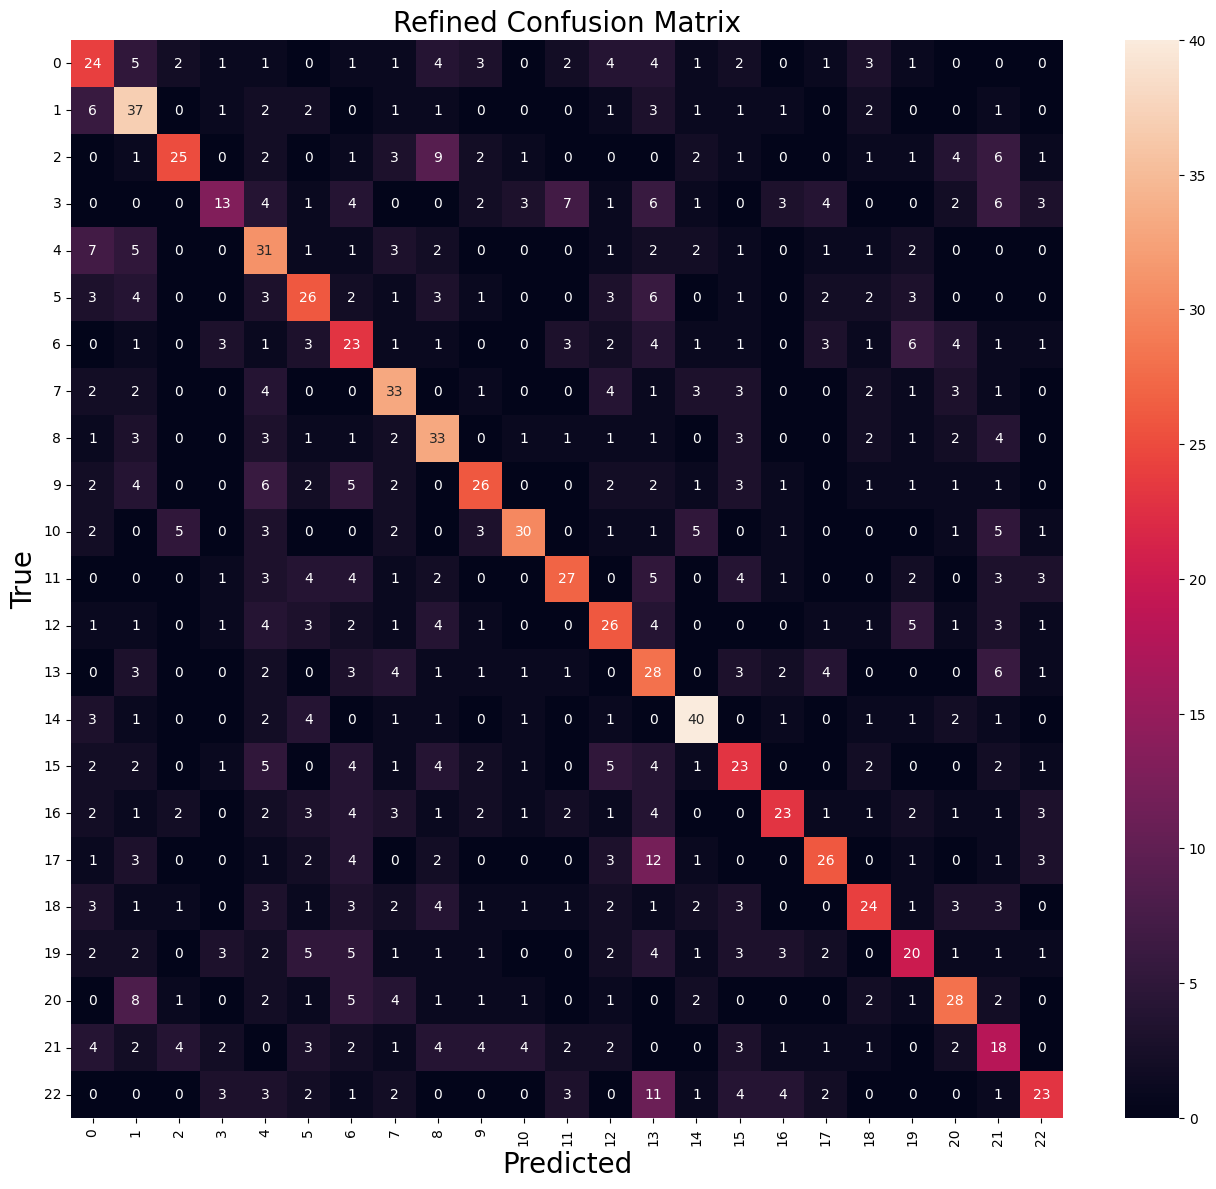

f1_score: 0.4411837572255302


In [ ]:
cm = confusion_matrix(actual_labels, predicted_labels)

labels = dataset.labels

fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g")
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()

ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')